# CVオークション予測

In [1]:
from os.path import dirname
import os
import datetime
from dateutil.relativedelta import relativedelta

import pandas as pd
import swifter
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
pd.set_option('display.max_columns', 50)

In [6]:
%reload_ext autoreload
from brandear_est import utils, dataset as bds, models, evals as ev, submit
from brandear_est.preprocess import pp_est_rank_weekly as pp

In [4]:
IMD_DIR = os.path.join(os.getcwd(), "../../data/intermediate/")
INPUT_DIR = os.path.join(os.getcwd(), "../../data/input")

IMD_INPUT_DIR = os.path.join(IMD_DIR, "pickled_inputs")
IMD_OUTPUT_DIR = os.path.join(IMD_DIR, "valid_aucs")
IMD_ARCHIVE_DIR = os.path.join(IMD_DIR, "arc_valid_aucs")

dset_to_period = {
    "pre_train": {"oldest": datetime.datetime(2019, 8, 26, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 3, 0, 0, 0)},    
    "train": {"oldest": datetime.datetime(2019, 9, 3, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 10, 0, 0, 0)},
    "valid_for_train": {"oldest": datetime.datetime(2019, 9, 10, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 17, 0, 0, 0),},    
    "valid_for_sub": {"oldest": datetime.datetime(2019, 9, 17, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 24, 0, 0, 0),},
    "submission": {"oldest": datetime.datetime(2019, 9, 24, 0, 0, 0),
              "newest": datetime.datetime(2019, 10, 1, 0, 0, 0),},    
}

## インプットデータ整理

In [7]:
# 元データ読み込み
auction = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "auction.pkl"))
watch = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "watch.pkl"))
bid = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "bid.pkl"))
bid_success = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "bid_success.pkl"))
sample_sub = pd.read_csv(os.path.join(os.getcwd(), "../../data/input" , "sample_submission.csv"))
sub_users = sample_sub[["KaiinID"]].drop_duplicates()
# ブランド作成日
brand = utils.read_csv(os.path.join(INPUT_DIR , "brand.csv"))
# itemcolorid付与(色の大分類)
color = utils.read_csv(os.path.join(INPUT_DIR , "color.csv"))
# カテゴリーid,itemdailID付与のためのItemShouID付与
genre = utils.read_csv(os.path.join(INPUT_DIR , "genre.csv"))
# itemshowID,itemdailID付与
itemshou = utils.read_csv(os.path.join(INPUT_DIR , "itemshou.csv"))
# itemlineID付与
line = utils.read_csv(os.path.join(INPUT_DIR , "line.csv"))

# オークション情報拡充
auction_mst = pp.build_auction_mst(
    auction=auction, itemshou=itemshou, genre=genre,
    brand=brand, color=color, line=line
)

Mem. usage decreased to  0.32 Mb (15.0% reduction)
Mem. usage decreased to  0.01 Mb (32.2% reduction)
Mem. usage decreased to  0.00 Mb (45.4% reduction)
Mem. usage decreased to  0.00 Mb (33.4% reduction)
Mem. usage decreased to  0.01 Mb (41.3% reduction)


## 特徴量エンジニアリング

In [16]:
%%time
for dset_type in ["pre_train", "train", "valid_for_train", "valid_for_sub", "submission"]:
    pp.build_dataset_input(
        auction=auction_mst,
        bid_success=bid_success,
        watch=watch,
        bid=bid,
        period=dset_to_period[dset_type],
        dset_type=dset_type,
        output_path=IMD_ARCHIVE_DIR
    )

##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']


KeyboardInterrupt: 

In [8]:
pre_train_dataset_input = pd.read_pickle(IMD_ARCHIVE_DIR + "/pre_train_feature.pkl")
train_dataset_input = pd.read_pickle(IMD_ARCHIVE_DIR + "/train_feature.pkl")
vt_dataset_input = pd.read_pickle(IMD_ARCHIVE_DIR + "/valid_for_train_feature.pkl")
vs_dataset_input = pd.read_pickle(IMD_ARCHIVE_DIR + "/valid_for_sub_feature.pkl")
sub_dataset_input = pd.read_pickle(IMD_ARCHIVE_DIR + "/submission_feature.pkl")

In [9]:
def agg_target_cols(df):
    df["actioned"] = np.array(df[["watch_actioned", "bid_actioned"]].astype(int)).max(axis=1)
    
agg_target_cols(pre_train_dataset_input)
agg_target_cols(train_dataset_input)
agg_target_cols(vt_dataset_input)
agg_target_cols(vs_dataset_input)
agg_target_cols(sub_dataset_input)

In [10]:
drop_cols = ([
    "AuctionID", "BrandCreateDate", "BrandID", "CategoryID", "ColorID", "ConditionID", "CreateDate", "GenreGroupID",
    "GenreID", "ItemColorID", "ItemDaiID", "ItemLineID", "ItemShouID", "LineCreateDate", "LineID", "ShouhinID",
    "ShouhinShubetsuID", "watch_actioned", "bid_actioned", "actioned"
])

ptr_dataset = bds.DataSet(data=pre_train_dataset_input, drop_cols=drop_cols, target_col="actioned")
tr_dataset = bds.DataSet(data=train_dataset_input, drop_cols=drop_cols, target_col="actioned")
vt_dataset = bds.DataSet(data=vt_dataset_input, drop_cols=drop_cols, target_col="watch_actioned")
vs_dataset = bds.DataSet(data=vs_dataset_input, drop_cols=drop_cols, target_col="watch_actioned")
sub_dataset = bds.DataSet(data=sub_dataset_input, drop_cols=drop_cols, target_col="watch_actioned")

## 予測

In [25]:
# # 学習の様子可視化
datasets = [ptr_dataset]
for dataset in datasets:
    
    # train test split
    train_dataset, test_dataset = bds.DataSet.train_test_split(dataset)

    # target encoding
    for cat_col in ["BrandID", "ItemShouID"]:
        train_dataset.add_target_encode(cat_col=cat_col)
        bds.target_encode_for_test(train_dataset=train_dataset, test_dataset=test_dataset, cat_col=cat_col)    
    
    lgb_bi = models.LgbBinaryClassifier()
    lgb_bi.train(train_dataset=train_dataset, valid_dataset=test_dataset, desc=True)    

[1]	valid_0's auc: 0.746983
[2]	valid_0's auc: 0.748668
[3]	valid_0's auc: 0.748749
[4]	valid_0's auc: 0.74883
[5]	valid_0's auc: 0.749084
[6]	valid_0's auc: 0.749263
[7]	valid_0's auc: 0.749263
[8]	valid_0's auc: 0.749341
[9]	valid_0's auc: 0.74927
[10]	valid_0's auc: 0.749568
[11]	valid_0's auc: 0.751543
[12]	valid_0's auc: 0.751648
[13]	valid_0's auc: 0.752115
[14]	valid_0's auc: 0.752671
[15]	valid_0's auc: 0.752887
[16]	valid_0's auc: 0.753297
[17]	valid_0's auc: 0.753495
[18]	valid_0's auc: 0.75402
[19]	valid_0's auc: 0.754496
[20]	valid_0's auc: 0.754611
[21]	valid_0's auc: 0.754788
[22]	valid_0's auc: 0.754845
[23]	valid_0's auc: 0.754648
[24]	valid_0's auc: 0.754627
[25]	valid_0's auc: 0.754756
[26]	valid_0's auc: 0.754811
[27]	valid_0's auc: 0.754795
[28]	valid_0's auc: 0.755499
[29]	valid_0's auc: 0.755435
[30]	valid_0's auc: 0.756147
[31]	valid_0's auc: 0.756518
[32]	valid_0's auc: 0.756658
[33]	valid_0's auc: 0.75672
[34]	valid_0's auc: 0.756941
[35]	valid_0's auc: 0.75704

In [11]:
# 予測値取得

dataset_pairs = [
    [ptr_dataset, tr_dataset],
    [tr_dataset, vt_dataset],
    [vt_dataset, vs_dataset],
    [vs_dataset, sub_dataset]
]

for train_dataset, sub_dataset in dataset_pairs:
    
    # target encoding
    for cat_col in ["BrandID", "ItemShouID"]:
        train_dataset.add_target_encode(cat_col=cat_col)
        bds.target_encode_for_test(train_dataset=train_dataset, test_dataset=sub_dataset, cat_col=cat_col)    

    lgb_bi = models.LgbBinaryClassifier()        
    lgb_bi.train(train_dataset=train_dataset)
    
    sub_dataset.set_pred(lgb_bi.predict(sub_dataset))    

In [ ]:
# be.df2pkl(tr_dataset.data, IMD_OUTPUT_DIR, f"train.pkl")
# be.df2pkl(vt_dataset.data, IMD_OUTPUT_DIR, f"valid_for_train.pkl")
# be.df2pkl(tr_dataset.data, IMD_OUTPUT_DIR, f"valid_for_sub.pkl")
# be.df2pkl(tr_dataset.data, IMD_OUTPUT_DIR, f"submission.pkl")

## 予測結果可視化

### auc

auc :  0.7279253804699506


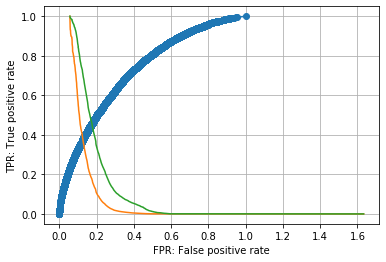

In [12]:
dataset = vs_dataset
print("auc : ", roc_auc_score(dataset.get_target(), dataset.data.pred))
ev.plot_roc_curve(dataset.get_target(), dataset.data.pred)
ev.plot_tpr_fpr(dataset.get_target(), dataset.data.pred)

### 残ったデータでどのくらいのndcgスコアが出せるか
### 正解データ、非正解データそれぞれの予測値分布

In [13]:
def show_th_info(th, dataset, dset_type):
    print("threshold : ", th)
    print("data size : ", dataset.data.shape[0])
    print("True count : ", dataset.data.query(f"({dataset.target_col} == 1)").shape[0])
    print("True and False larger than threshold : ", dataset.data.query(f"pred >= {th}").shape[0])
    print("True larger than threshold : ", dataset.data.query(f"(pred >= {th}) & ({dataset.target_col} == 1)").shape[0])
    y_true = pp.extract_target_actions(watch, bid, dset_to_period[dset_type])
    print("Target pair size", y_true.shape[0])
    cheat_pred = submit.get_cheat_pred(
        dataset.data.query(f"pred >= {th}")[["AuctionID", "pred"]].merge(y_true[["AuctionID", "KaiinID"]], on="AuctionID", how="inner"),
        y_true
    )
    cheat_sub = submit.adjust_sub_form(y_true[["KaiinID"]].drop_duplicates(), cheat_pred, drop=True)
    print(ev.calc_ndcg(y_true, cheat_sub).mean())
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
    axL.hist(dataset.data.query(f"({dataset.target_col} == 1)").pred, bins=100)
    axR.hist(dataset.data.query(f"({dataset.target_col} != 1)").pred, bins=100)

threshold :  0.1
data size :  364608
True count :  45441
True and False larger than threshold :  221217
True larger than threshold :  38934
Target pair size 91044
0.7674918412437286


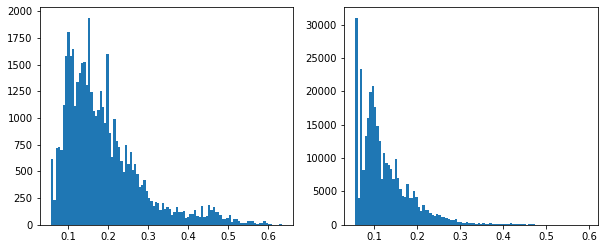

In [17]:
show_th_info(0.1, vs_dataset, "valid_for_sub")